In [1]:
from helpers import toWei, fromWei, UsdEthConverter, Market

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

usd = UsdEthConverter(162) # $162 per ETH on 10/24

In [2]:
params = {
    'price_floor':          0,   # wei per billion CMT-wei

    'spread':               110,  # percentage
    
    'list_reward':          toWei(2, 'CMT'),
    # Keep this low but not negligible. Excpet FFA to potentially get many valid candidates
    # that are voted in but never bought. Don't let these cruft listings soak up too much 
    # capitalization. Incentive for makers should be listing something that will sell.
    
    'stake':                toWei(10, 'CMT'),
    
    'backend_payment':      5, # percent
    
    'maker_payment':        30, # percent. 
    
    # reserve payment:      100 - backend_payment - maker_payment
    
    'usd_cost_per_mbyte':       0.10 # $USD per Mbyte
    # A scan through some Kaggle datasets, the size of videos, photos, and sound files, and came
    # up with 100MB as a reference listing size. Let's make buying this reference 1 ETH. You can 
    # easily get 3 ETHs from the faucet and buy 3 things.
}

In [3]:
# Convert human readable units to units used by market codebase
params['reserve_payment'] = 100 - params['backend_payment'] - params['maker_payment']
params['cost_per_byte'] = toWei(usd.toEth(params['usd_cost_per_mbyte']), 'ETH') / 1e6

# for k in params:
#     print (f"{k}: {params[k]}")

## Set up market with 3 creators each investing $166

In [4]:
m = Market(params)
m.market_total += toWei(100000, 'CMT')
m.reserve += toWei(100000, 'CMT')

CREATOR_BLOCK_SIZE = m.market_total

print (f"\nCMT support price is now ${round(usd.fromEth(m.get_human_support_price()),2)}")
print (f"CMT withdraw price is now ${round(usd.fromEth(m.get_withdraw_price()),2)}")
print ("\n")

print (f"• Market reserve is {round(fromWei(m.reserve, 'ETH'),3)} ETH (${round(usd.fromEth(fromWei(m.reserve, 'ETH')),2)})")
print (f"• Total market tokens is {round(fromWei(m.market_total, 'CMT'), 2)} CMT")
       
# print ("\n")
# print (f"• The creator has {int(CREATOR_BLOCK_SIZE/params['stake'])} stakes of voting power")

# listings_approved_to_match_creator = CREATOR_BLOCK_SIZE / params['list_reward']
# print (f"• It takes {int(listings_approved_to_match_creator)} listings to match creator voting power")


CMT support price is now $178.2
CMT withdraw price is now $162.0


• Market reserve is 100000.0 ETH ($16200000.0)
• Total market tokens is 100000.0 CMT


In [5]:
m.support(1.0)

In [6]:
usd.fromEth(m.get_human_support_price())

178.20016183799999

## Scenario: simple sequence of supporting, listing, buying

In [7]:
iters = 10000
buys_per_iter = 100

support_prices_usd = np.zeros(iters)
withdraw_prices_usd = np.zeros(iters)
buy_total_volume_usd = np.zeros(iters)

support_usd = 500.0
buy_mb = 100.0

buy_volume_mb = 0

for i in range(iters):
    m.support(usd.toEth(support_usd))
#     m.list()
#     for j in range(10):
#         m.buy(buy_mb)
#         buy_volume_mb += buy_mb

    support_prices_usd[i] = m.get_human_support_price()
    withdraw_prices_usd[i] = m.get_withdraw_price()
    buy_total_volume_usd[i] = buy_volume_mb * params['usd_cost_per_mbyte']

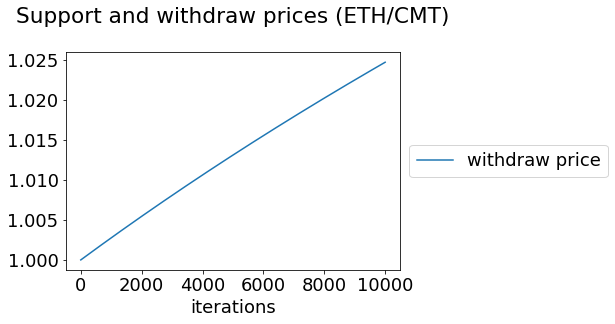

In [8]:
plt.rc('font', size=18)
fig, ax = plt.subplots()

x = np.arange(0, iters, 1)
# ax.plot(x, support_prices_usd)
ax.plot(x, withdraw_prices_usd)
ax.legend(['withdraw price'], loc='center left', bbox_to_anchor=(1, 0.5))

ax.set(xlabel='iterations', title='Support and withdraw prices (ETH/CMT)\n')
plt.show()

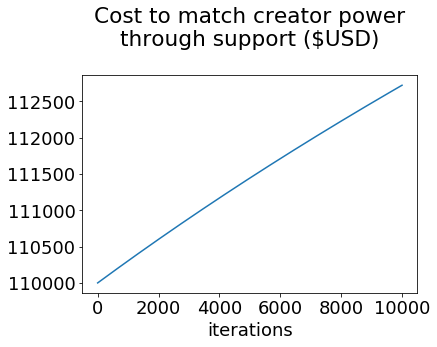

In [9]:
costs_to_match_creator = fromWei(CREATOR_BLOCK_SIZE, 'CMT') * support_prices_usd

fig, ax = plt.subplots()
ax.plot(x, costs_to_match_creator)
ax.set(xlabel='iterations', title='Cost to match creator power\nthrough support ($USD)\n')
plt.show()

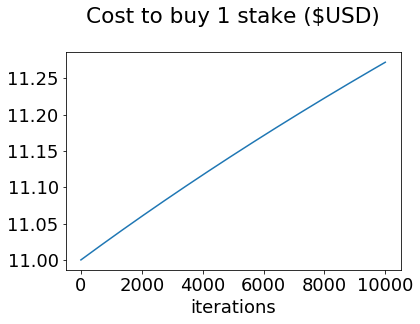

In [10]:
costs_to_stake = fromWei(params['stake'], 'CMT') * support_prices_usd

fig, ax = plt.subplots()
ax.plot(x, costs_to_stake)
ax.set(xlabel='iterations', title='Cost to buy 1 stake ($USD)\n')
plt.show()

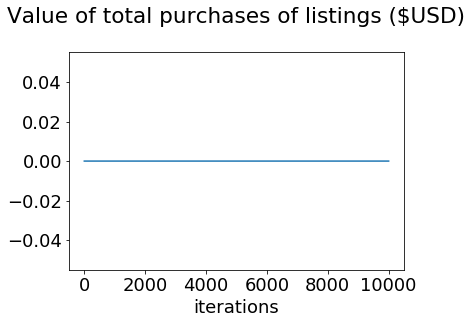

In [11]:
fig, ax = plt.subplots()
ax.plot(x, buy_total_volume_usd)
ax.set(xlabel='iterations', title='Value of total purchases of listings ($USD)\n')
plt.show()

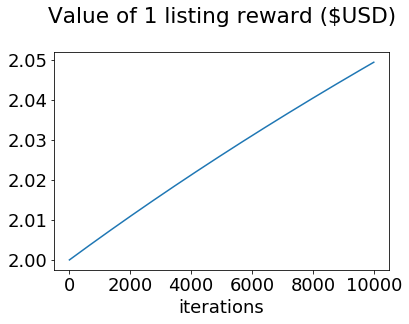

In [12]:
reward = fromWei(params['list_reward'], 'CMT') #CMT
prices = withdraw_prices_usd
usd_rewards = reward * prices

fig, ax = plt.subplots()
ax.plot(x, usd_rewards)
ax.set(xlabel='iterations', title='Value of 1 listing reward ($USD)\n')
plt.show()

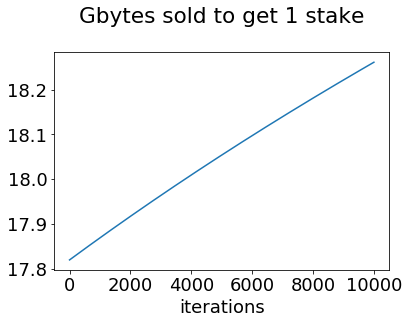

In [13]:
mb_sold_to_stake = costs_to_stake / (fromWei(params['cost_per_byte'], 'ETH') * 1e6)
fig, ax = plt.subplots()
ax.plot(x, mb_sold_to_stake/1000)
ax.set(xlabel='iterations', title='Gbytes sold to get 1 stake\n')
plt.show()

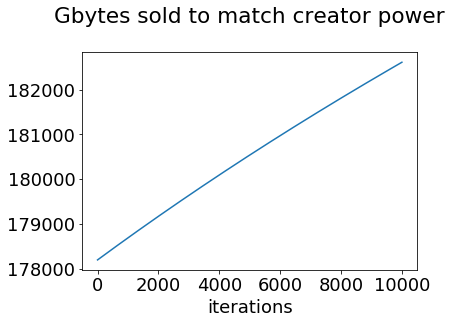

In [14]:
mb_sold_to_match_creator = costs_to_match_creator / (fromWei(params['cost_per_byte'], 'ETH') * 1e6)
fig, ax = plt.subplots()
ax.plot(x, mb_sold_to_match_creator/1000)
ax.set(xlabel='iterations', title='Gbytes sold to match creator power\n')
plt.show()